In [0]:
# Commented out IPython magic to ensure Python compatibility.
from google.colab import files
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

In [2]:
print(tf.__version__)

2.2.0


In [3]:
uploaded = files.upload()

Saving style_3.jpeg to style_3 (3).jpeg


In [4]:
uploaded = files.upload()

Saving myself.jpg to myself (3).jpg


In [0]:
# Load the content and style images
content = plt.imread('myself.jpg')
style = plt.imread('style_3.jpeg')

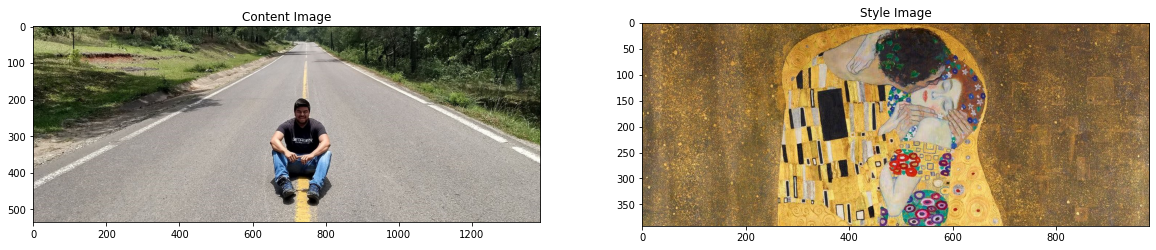

In [6]:
# Display the images
fig, (c, s) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
c.imshow(content)
c.set_title('Content Image')
s.imshow(style)
s.set_title('Style Image')
plt.show()

***This function transform the images into arrays and reshape them with the aim of making them compatible***



In [0]:
def load_image(image_loaded):
  image_loaded = plt.imread(image_loaded)
  img = tf.image.convert_image_dtype(image_loaded, tf.float32)
  img = tf.image.resize(img, [500, 1200]) #change in case the image looks strange
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [8]:
#Make shure it has the same compability
content = load_image('myself.jpg')
style = load_image('style_3.jpeg')

# Verify the shapes
content.shape, style.shape

(TensorShape([1, 500, 1200, 3]), TensorShape([1, 500, 1200, 3]))

***`Get the model of VGG19`***

In [0]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

***Just take the weights till conv4_2 for the content layer layers and conv5 for style_layers this is recomended to get better results***

In [0]:
# Content layer
cont_layers = ['block4_conv2']

#To get the content features, 
#the second convolutional layer from the fourth block (of convolutional layers) is used.
#For convenience, the authors of the paper named it to be conv4_2.

# Style layer
st_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']

num_cont_layers = len(cont_layers)
num_st_layers = len(st_layers)

***This model will run the specified layers to get the necessary features.***

In [0]:
def do_model(names_layer, model):

  outputs = [model.get_layer(name).output for name in names_layer]

  #This line creates a model with one input (vgg.input) an one or more outputs
  model = Model([vgg.input], outputs) 
  return model

***flatten the matrix to star calculating the relation between filters***

In [0]:
# Gram matrix
# You flatten the first two dimensions of the convolved image and turn them into a 1D vector
def gram_matrix(matrix):
  temp = matrix
  temp = tf.squeeze(temp) #flatten the matrix
  #start making the gram proces (Variance)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]]) 
  result = tf.matmul(temp, temp, transpose_b=True)
  gram_process = tf.expand_dims(result, axis=0)
  return gram_process # gram matrix would denote the similarities between the feature maps
  #this is used to obtain the Style loses

***This Class will take our model and return the output of the different layers in each iteration***

In [0]:
class Style_Model_func(tf.keras.models.Model):

  def __init__(self, st_layers, cont_layers):
    super(Style_Model_func, self).__init__()
    #adding the features maps to mix with input features layers
    self.vgg =  do_model(st_layers + cont_layers, vgg)
    self.st_layers = st_layers
    self.cont_layers = cont_layers
    self.num_st_layers = len(st_layers)
    self.vgg.trainable = False #freeze the weights 

  #This funtion is where the image content is changing with the style transfered
  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Getting the features of each image ---->(size1,size2,chanels)
    features_input = preprocess_input(inputs)
    # call the model 
    outputs_features = self.vgg(features_input)
    # Obtain the style and the content representations 
    #This is done by calculating correlations between the convolutional layers
    st_outputs, cont_outputs = (outputs_features[:self.num_st_layers],
                                      outputs_features[self.num_st_layers:])

    # Calculate the gram matrix for each layer (variance)
    # Determine how similar are the features across the feature maps within a single convolutional layer
    st_outputs = [gram_matrix(style_output)
                     for style_output in st_outputs]

    #For each feature map, you can measure how strongly its detected features relate to the other feature maps in the same layer

    # Store the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    #pass the content outputs to the content layers
                    in zip(self.cont_layers, cont_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  #pass the style outputs to the style layers
                  in zip(self.st_layers, st_outputs)}

    return {'content':content_dict, 'style':style_dict}

# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Style_Model_func(st_layers, cont_layers)
#extract_layers style/Content to later obtain the loss
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

***It is used Adam optimization by getting stochastis (random) gradients descents***

In [0]:
adam = tf.optimizers.Adam(learning_rate=0.02)

***This hyperparameters we can play with***

In [0]:
# Here you can provide custom weights to the differentconvolution blocks
# to attain a detailed representation of the style. 
# Suggestion weights for style and content updates
style_weight=100
content_weight=10

# Suggestion weights for different style layers
style_weights = {'block1_conv1': 1,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

***Get the loss function***

![alt text](https://res.cloudinary.com/dchysltjf/image/upload/f_auto,q_auto:best/v1561051055/Screen_Shot_2019-06-20_at_1.16.56_PM.png)


In [0]:
#Content loss, which makes sure that the net amount of content is preserved.
#Style loss which takes care of the amount of style getting transferred to the target image.
def total_loss(outputs_features):
    st_outputs = outputs_features['style']
    cont_outputs = outputs_features['content']
    #use of MeanSquareError to get the loss  
    #Measure how far are the features of the content and target images from one another. 
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((st_outputs[name]-style_targets[name])**2)
                           for name in st_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_st_layers
    #use of MeanSquareError to get the loss
    content_loss = tf.add_n([tf.reduce_mean((cont_outputs[name]-content_targets[name])**2)
                             for name in cont_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_cont_layers
    loss = style_loss + content_loss
    return loss

***It is used GradientTape to obtain the gradients of each function and tf.fucntion to speed up the operations.***

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs_features = extractor(image)
    # Calculate the loss of each epoch
    loss = total_loss(outputs_features)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  adam.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [0]:
target_image = tf.Variable(content)

# ***Start the Process***

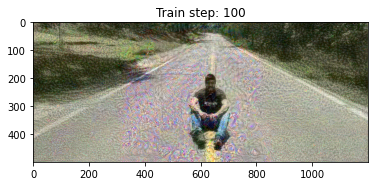

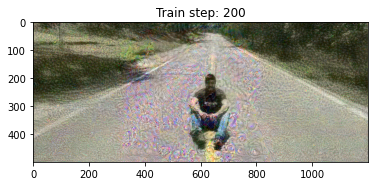

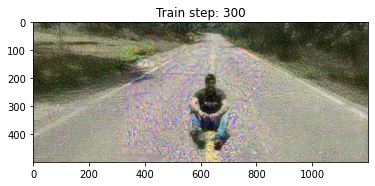

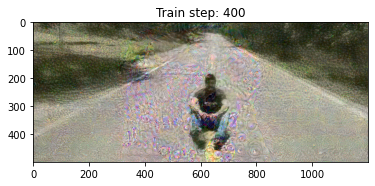

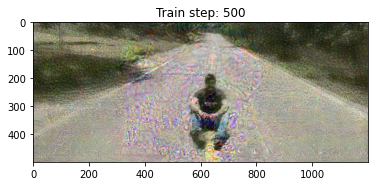

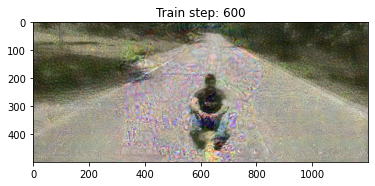

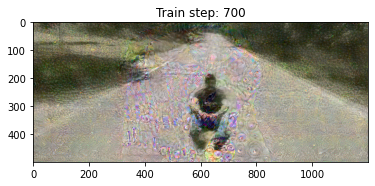

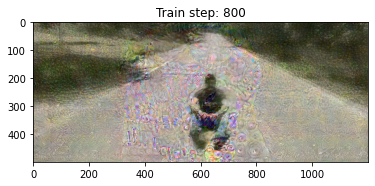

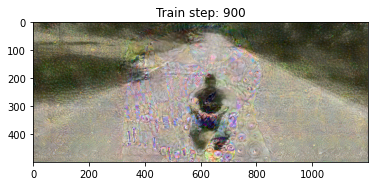

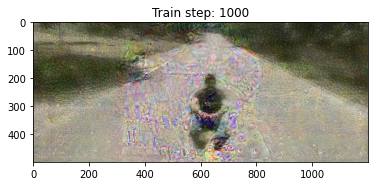

In [20]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()